In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import control as ct
from qpsolvers import cvxopt_solve_qp as solve_qp
from matplotlib import animation
from scipy import signal
import math

In [2]:
N=1000
t=np.arange(N)*(1/4000)

In [3]:
x_0=[0.1999]

In [4]:
def f (x):
    return 1.5*x

In [5]:
def g (x): 
    return 1

In [6]:
phi=lambda x: 1-25*x**2

In [7]:
grad_phi=lambda x: -50*x

In [8]:
def u_nominal (x):
    return -x

In [9]:
#Hyperparameters

theta=0.001
margin=0.0
correction_strength=4
#alpha=10

In [10]:
Ts=1/4000
U=np.zeros(N)
S=np.zeros(N)
Dot_X=np.zeros(N)
last_u=0
#last_u=u_nominal(x_0)
global_state=0
global_u=0
#global_timer=0
count=0

In [11]:
def sign_flipper(x,last_u):
    global global_state      #This is cf of algo
    global global_u
    dot_x=0
    dot_x= f(x)+np.dot(g(x),last_u)
    dot_phi=np.dot(grad_phi(x),dot_x)
    #print("at time", count, "CBF=",phi(x))
    if ((global_state==0)and((phi(x)>theta) or (dot_phi >= 0))):
        u=u_nominal(x)
        global_state=0
    else:
        if (global_state==1):
            u=global_u
            dot_x_plus=f(x)+np.dot(g(x),u)
            dot_phi_plus=np.dot(grad_phi(x),dot_x_plus)
            if((dot_phi_plus<0) or (phi(x)>theta+margin)):
                global_state=0
            #print("correction applied again!")
        else:
            u=last_u-2*correction_strength*np.dot(1/(g(x)),dot_x)
            global_u=u
            global_state=1
            #print("correction applied.")
    last_u=u
    return u

In [12]:
def sign_flipper_2(x,last_u):
    dot_x=0
    dot_x= f(x)+np.dot(g(x),last_u)
    dot_phi=np.dot(grad_phi(x),dot_x)
    #print("at time", count, "CBF=",phi(x))
    if (phi(x)>theta):
        u=u_nominal(x)
    else:
        if (dot_phi>=0):
            u=last_u
        else:
            u=last_u-2*correction_strength*np.dot(1/(g(x)),dot_x)
            #print("correction applied.")
    last_u=u
    return u
    

In [13]:
def play_dynamics(X):
    global count
    global last_u
    #u=u_nominal(X)
    #u=sign_flipper(X,last_u)
    u=sign_flipper_2(X,last_u)
    if (count < N):
        U[count]=u
        S[count]=X
        Dot_X[count]=f(X)+np.dot(g(X),u)
        last_u=u
        count=count+1
    return (f(X)+np.dot(g(X),u))

In [14]:
def dynamics_runner(x_0,t):
    d=t.shape[0]
    X_0=np.copy(x_0)
    X=x_0
    X=np.expand_dims(X_0,axis=0)
    #print(np.shape(X))
    dt=t[1]-t[0]
    for i in range(d):
        dX=dt*play_dynamics(X[i])
        #print(dX)
        X_n=X[i]+dX
        X=np.append(X,[X_n],axis=0)
    return X

In [15]:
X=dynamics_runner(x_0,t)

In [16]:
phi_test=np.zeros(N)
for i in range(N):
    phi_test[i]=phi(S[i])

Text(0.5, 1.0, 'Barrier zeroing function $phi(X)$')

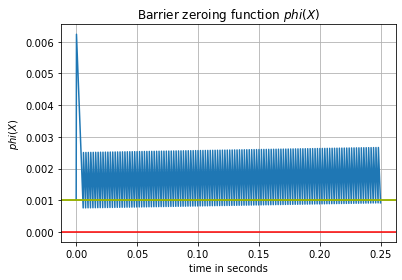

In [17]:
plt.figure()
plt.plot(t[0:N], phi_test[0:N]); plt.axhline(y = 0, c = 'r');plt.axhline(y=theta,c='g'); plt.axhline(y=theta+margin,c='y'); plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('$phi(X)$')
plt.title('Barrier zeroing function $phi(X)$')

Text(0.5, 1.0, 'control variable norm dynamics')

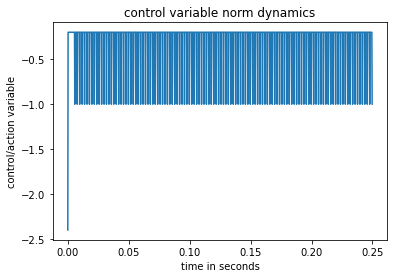

In [18]:
plt.figure()
#U_norm=np.linalg.norm(U,axis=0)
plt.plot(t[0:N],U[0:N])
plt.xlabel('time in seconds')
plt.ylabel('control/action variable')
plt.title('control variable norm dynamics')

In [19]:
%store phi_test

Stored 'phi_test' (ndarray)
